In [1]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

In [2]:
IBMQ.save_account( '')

Credentials already present. Set overwrite=True to overwrite.


In [3]:
qr = QuantumRegister(2)
cr = ClassicalRegister(2)

groverCircuit = QuantumCircuit(qr,cr)

In [4]:
groverCircuit.h(qr)

In [5]:
groverCircuit.x(qr)
groverCircuit.cz(qr[0],qr[1])
groverCircuit.x(qr)

In [6]:
groverCircuit.h(qr)


In [7]:
groverCircuit.z(qr)
groverCircuit.cz(qr[0],qr[1])

In [8]:
groverCircuit.h(qr)

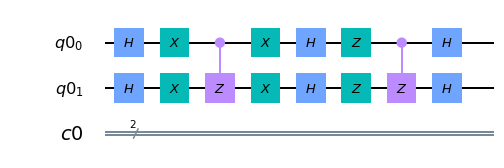

In [9]:
groverCircuit.draw(output="mpl")

In [10]:
backend_sim = Aer.get_backend('statevector_simulator')
job_sim = execute(groverCircuit, backend_sim)
statevec = job_sim.result().get_statevector()
print(statevec)

[ 1.00000000e+00-2.44929360e-16j -1.06737325e-48-8.71576399e-33j
  0.00000000e+00+2.46519033e-32j  1.06737325e-48+8.71576399e-33j]


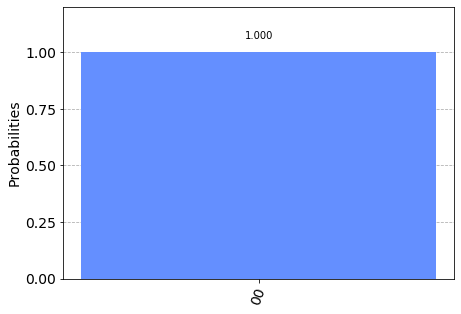

In [11]:
groverCircuit.measure(qr,cr)

backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(groverCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

In [12]:
# Load IBM Q account and get the least busy backend device
provider = IBMQ.load_account()
device = least_busy(provider.backends(simulator=False))
print("Running on current least busy device: ", device)

C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\providers\models\backendconfiguration.py:337: UserWarning: `dt` and `dtm` now have units of seconds(s) rather than nanoseconds(ns).
  warnings.warn('`dt` and `dtm` now have units of seconds(s) rather '


Running on current least busy device:  ibmq_ourense


In [13]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
job = execute(groverCircuit, backend=device, shots=1024, max_credits=10)
job_monitor(job, interval = 2)

Job Status: job has successfully run


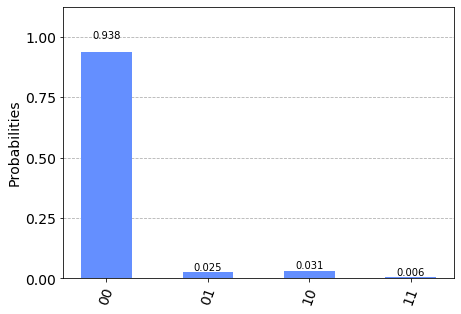

In [14]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(groverCircuit)
plot_histogram(answer)

In [15]:
def phase_oracle(circuit, register):
    circuit.cz(qr[2],qr[0])
    circuit.cz(qr[2],qr[1])

In [16]:
def n_controlled_Z(circuit, controls, target):
    """Implement a Z gate with multiple controls"""
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 controls is not implemented')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)

In [17]:
def inversion_about_average(circuit, register, n, barriers):
    """Apply inversion about the average step of Grover's algorithm."""
    circuit.h(register)
    circuit.x(register)
    
    if barriers:
        circuit.barrier()
    
    n_controlled_Z(circuit, [register[j] for j in range(n-1)], register[n-1])
    
    if barriers:
        circuit.barrier()
    
    circuit.x(register)
    circuit.h(register)

In [18]:
barriers = True

qr = QuantumRegister(3)
cr = ClassicalRegister(3)

groverCircuit = QuantumCircuit(qr,cr)
groverCircuit.h(qr)

if barriers:
    groverCircuit.barrier()

phase_oracle(groverCircuit, qr)

if barriers:
    groverCircuit.barrier()

inversion_about_average(groverCircuit, qr, 3, barriers)

if barriers:
    groverCircuit.barrier()

groverCircuit.measure(qr,cr)


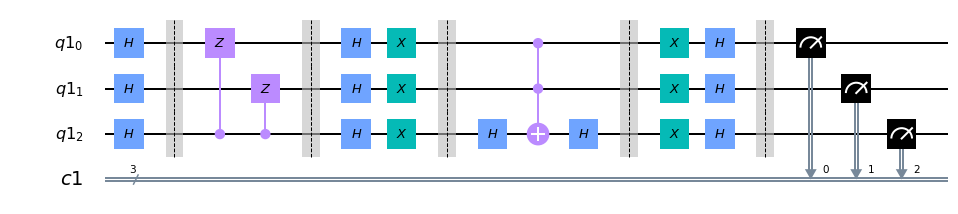

In [19]:
groverCircuit.draw(output="mpl")

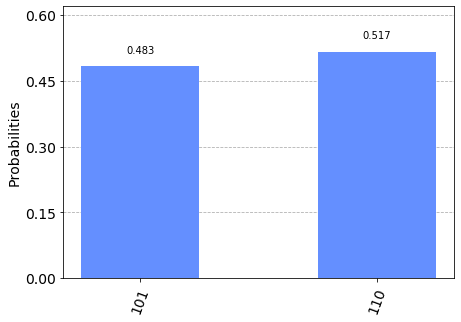

In [20]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(groverCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

In [21]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits <= 5 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_ourense


In [22]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
job = execute(groverCircuit, backend=backend, shots=shots)

job_monitor(job, interval = 2)

Job Status: job has successfully run


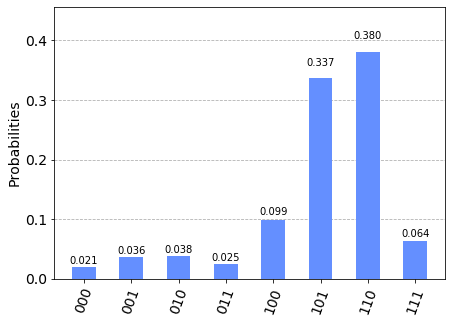

In [23]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(groverCircuit)
plot_histogram(answer)